# Introdução 
Estudo realizado para preparar o ds para treino e validação de modelos ML
1. Limpeza de Dados \
Tratar valores ausentes \
Remover duplicados e corrigir inconsistências
2. EDA \
Visualizar e entender o DS \
Identificar padrões, outliers e correlações entre variáveis
3. Feature Importance \
Utilização de Random Forest para perceber importânica das variáveis
4. Preparação do DS para Modelos \
DS pronto para utilização num modelo

# Libraries

In [1]:
import numpy as np # library para cálculos numéricos
import pandas as pd # library para manipulação de dados
import matplotlib.pyplot as plt # library para criar gráficos
import seaborn as sns # library para melhorar estética de gráficos
import os # library para trabalhar com o SO

from sklearn.ensemble import RandomForestClassifier # modelo baseado em árvores de decisão, usado para classificação 
from sklearn.model_selection import train_test_split, cross_val_score # bibliotecas para dividir dados em treino e teste | biblioteca para cross validation
from sklearn.metrics import confusion_matrix, classification_report # matriz confusão para avaliar performance do modelo | relatório com métricas

from scipy import stats # módulo para realizar testes e análises de dados

# FUNÇÕES DE AJUDA

# Identificar Var Numéricas e Categóricas

In [2]:
def get_feature_types(df, target_col='Attack Type'):
    """
    Identifica e separa as colunas numéricas e categóricas do df, excluindo a coluna (target).

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame que contém o DS
    target_col : str, optional (default='Attack Type')
        Nome da coluna target

    Returns:
    --------
    tuple : (list, list)
        Duas listas que contém:
        - numeric_features: Lista de colunas com dados numéricos
        - categorical_features: Lista de colunas com dados categóricos
    """

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist() # Seleciona todas as colunas numéricas e converte os nomes selecionados para uma lista
    categorical_features = df.select_dtypes(include=['object']).columns.tolist() # Seleciona todas as colunas categóricas e converte os nomes selecionados para uma lista

    # Remoção da coluna target, se presente
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features # Retorna as duas listas

# Analizar Correlação Entre Features Numéricas

In [3]:
def correlation_analysis(df, numeric_features, threshold=0.85):
    """
    Análise da correlação entre variáveis numéricas.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame que contém o DS
    numeric_features : list
        Lista de colunas numéricas a analizar
    threshold : float
        Definição de valor mínimo absoluto de correlação para duas features serem consideradas altamente correlacionadas

    Returns:
    --------
    list of tuples
        List of highly correlated feature pairs and their correlation values
        Each tuple contains (feature1, feature2, correlation_value)

    Notes:
    ------
    - Cria um heatmap com as correlações
    - Identifica pares de features com correlação > 0.85
    """
 
    corr_matrix = df[numeric_features].corr() # Seleciona as colunas numéricas e calcula a matriz de correlação

    # Criação do heatmap de correlação    
    plt.figure(figsize=(20, 20))   
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identificar features com alta correlação
    threshold = threshold # Mantém o valor limite da correlação que será utilizada na análise
    high_corr = np.where(np.abs(corr_matrix) > threshold) # Converter tudo para valores absolutos e compara com o threshold definido

    # Criação da lista com pares de features altamente correlacionadas
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr # Retorna a lista com o formato (feature1, feature2, valor de correlação)

# Análise de Homogeneidade da Variância (Teste de Levene's)

In [4]:
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):  
    """  
    Verifica a homogeneidade da variância entre os grupos de cada feature numérica.

    Parameters:  
    -----------  
    df : pandas.DataFrame
        Input DataFrame que contém o DS 
    numeric_features : list
        Lista de colunas numéricas a analizar
    target_col : str, optional (default='Attack Type')
        Nome da coluna target

    Returns:  
    --------  
    dict  
        Dicionário contento os resultados do teste de Levene para cada feature numérica
    """  
    
    results_levene = {}  
    
    for feature in numeric_features:  
        # Agrupa os dados com base nos valores únicos da variável target_col
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)   
                  if not group[feature].dropna().empty]  
        
        # Filtrar grupos inválidos (Teste de Levene não pode ser realizado sem variabilidade de dados)
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]  
        
        # Verifica se existem dois grupos válidos 
        if len(groups) < 2:  
            print(f"Sem grupos válidos suficientes para realizar o teste de  Levene's para as features: {feature}")  
            continue 

        # Executa Levene's Test e guarda no dicionário
        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene

# Análise da Importância das Features com Teste Kurskal-Wallis

In [5]:
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):
    """  
    Avaliar a importância das features numéricas com base no teste Kruskal-Wallis.

    Parameters:  
    -----------  
    df : pandas.DataFrame
        Input DataFrame que contém o DS 
    numeric_features : list
        Lista de colunas numéricas a analizar
    target_col : str, optional (default='Attack Type')
        Nome da coluna target

    Returns:  
    --------  
    pandas.DataFrame  
        DataFrame que contém H-statistics e p-values para cada feature.

    Notes:  
    ------  
    - Usa Kruskal-Wallis test para avaliar a feature importance  
    - H-statistic mais elevado indica relação mais elevada com variável target     
    """  

    h_scores = {}  
    
    for feature in numeric_features:  
        # Agrupa os dados pelo valor da variável objetivo e realiza o Kruskal-Wallis test  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)] 
        # Executa o teste de Kruskal-Wallis 
        h_stat, p_val = stats.kruskal(*groups)  
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

    # Cria um DS com os resultados  
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')  
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)  

    # Cria um gráfico de barras para a importância das features 
    plt.figure(figsize=(18, 10))  
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
    plt.xlabel('Features')  
    plt.ylabel('H-statistic')  
    plt.tight_layout()  
    plt.show()  

    return h_scores_df

# Análise da Importância das Features com Random Forest

In [6]:
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    """
    Determinar a importância das features na previsão do objetivo (target_col), usando um Random Forest Classifier

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame que contém o DS 
    numeric_features : list
        Lista de colunas numéricas a analizar
    target_col : str, optional (default='Attack Type')
        Nome da coluna target

    Returns:
    --------
    pandas.DataFrame
        DataFrame que contém a importância das features ordenadas por importânica de forma decrescente
    cm
        Matriz confusão para avaliar performance do modelo
    rf_labels
        Labels do modelo
    cv_scores
        Cross-validation scores para referência futura

    Notes:
    ------
    - Usa Random Forest classifier.
    """

    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Número de árovres
        'max_depth': 30,        # Profundidade máxima das árvores
        'random_state': 42,     # Para reprodutibilidade
        'n_jobs': -1            # Utiliza todos os núcleos do processador
    }

    # Separação das features numéricas e variável objetivo
    X = df[numeric_features]
    y = df[target_col]

    # Divisão dos dados em treino e teste (70-30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Cria e treina o modelo Random Forest
    rf = RandomForestClassifier(**hyperparameters)

    # Adapta o modelo ao conjunto de treino
    rf.fit(X_train, y_train)

    # Cross-validation no set de treino
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}') # Média de DesvPad dos scores
    
    # Previsão ao conjunto de teste
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calcula scores do teste, incluindo precisão, recall e f1-score
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Gráfico com a importância das features
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

# Cálculo da Percentagem de Outliers para Cada Feature com IQR

In [7]:
def calculate_outliers_percentage(df):
    """
    Calcular a percentagem de outliers para cada feature numérica do Ds, utilizando o método IQR.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame que contém o DS.

    Returns:
    --------
    dict
        Dicionário que contém a percentagem de outliers para cada feature.

    Notes:
    ------
    - Usa o método (IQR) para identificar outliers.
    - Outliers definidos por valores abaixo de Q1 - 1.5 * IQR ou acima Q3 + 1.5 * IQR.
    - A função retorna um dicionário com os nomes das feature como keys e percentagens de outliers como valores.
    """

    outlier_percentages = {}

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # Q1
        Q3 = df[column].quantile(0.75)  # Q3
        IQR = Q3 - Q1  # IQR

        lower_bound = Q1 - 1.5 * IQR  # Valor mínimo para outliers
        upper_bound = Q3 + 1.5 * IQR  # Valor máximo para outliers

        # Identifica outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calcula a percentagem de outliers
        outlier_percentage = len(outliers) / len(df) * 100

        # Armazena a percentagem de outliers
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

# 1. EXPLORAÇÃO INICIAL

# 1.1. Carregar o Ds

In [8]:
# Lista para armazenar DataFrames
dfs = []

# Carregar os DS
for dirname, _, filenames in os.walk('ds'):
    for filename in filenames:
        dfs.append(pd.read_csv(os.path.join(dirname, filename))) # Adiciona os DataFrames à lista

In [9]:
# Dimensão de cada DataFrame
for i, data in enumerate(dfs, start=1):
    rows, cols = data.shape
    print(f'df{i} -> {rows} rows, {cols} columns')

df1 -> 288602 rows, 79 columns
df2 -> 529918 rows, 79 columns
df3 -> 191033 rows, 79 columns
df4 -> 286467 rows, 79 columns
df5 -> 225745 rows, 79 columns
df6 -> 445909 rows, 79 columns
df7 -> 692703 rows, 79 columns
df8 -> 170366 rows, 79 columns


# 1.2. Junção dos Dataframes

In [10]:
# Concatenação de todos os DataFrames
data = pd.concat(dfs, axis=0, ignore_index=True)

# Apaga Dataframes individuais
for df in dfs: del df

# 1.3. Overview dos Dados

In [11]:
# Display das primeiras linhas
data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0                 22             166                   1   
1              60148              83                   1   
2                123           99947                   1   
3                123           37017                   1   
4                  0       111161336                 147   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        1                            0   
1                        2                            0   
2                        1                           48   
3                        1                           48   
4                        0                            0   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       0   
1                             0                       0   
2                            48                      48   
3                            48                      48   
4                             0                       0   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                       0                      0.0                     0.0   
1                       0                      0.0                     0.0   
2                      48                     48.0                     0.0   
3                      48                     48.0                     0.0   
4                       0                      0.0                     0.0   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...                     32        0.000        0.000            0   
1  ...                     32        0.000        0.000            0   
2  ...                     40        0.000        0.000            0   
3  ...                     32        0.000        0.000            0   
4  ...                      0  1753752.625  2123197.578      4822992   

    Active Min  Idle Mean     Idle Std   Idle Max   Idle Min   Label  
0            0        0.0        0.000          0          0  BENIGN  
1            0        0.0        0.000          0          0  BENIGN  
2            0        0.0        0.000          0          0  BENIGN  
3            0        0.0        0.000          0          0  BENIGN  
4           95  9463032.7  2657727.996   13600000    5700287  BENIGN  

[5 rows x 79 columns]

In [12]:
# Apresentação de 10 linhas aleatórias
data.sample(n=10, random_state=42)

Destination Port   Flow Duration   Total Fwd Packets  \
746827                  53           30767                   2   
946912                  53           48461                   2   
2216843                 80               1                   2   
699389                  53             191                   2   
1170268               2126              33                   1   
800686               44761              52                   1   
1434488              31843         4000835                   1   
1968368                443        60397661                  13   
934343                 443          263886                   6   
693547               52676              36                   1   

          Total Backward Packets  Total Length of Fwd Packets  \
746827                         2                           70   
946912                         2                           76   
2216843                        0                            0   
699389                         2                           74   
1170268                        1                            0   
800686                         1                            0   
1434488                        4                         1375   
1968368                       12                          984   
934343                        10                         1091   
693547                         1                            6   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
746827                            102                      35   
946912                            200                      38   
2216843                             0                       0   
699389                            138                      37   
1170268                             6                       0   
800686                              0                       0   
1434488                            18                    1375   
1968368                          3402                     596   
934343                           4995                     549   
693547                              6                       6   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
746827                       35                35.000000   
946912                       38                38.000000   
2216843                       0                 0.000000   
699389                       37                37.000000   
1170268                       0                 0.000000   
800686                        0                 0.000000   
1434488                    1375              1375.000000   
1968368                       0                75.692308   
934343                        0               181.833333   
693547                        6                 6.000000   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
746827                 0.000000  ...                     20       0.0000   
946912                 0.000000  ...                     20       0.0000   
2216843                0.000000  ...                     32       0.0000   
699389                 0.000000  ...                     32       0.0000   
1170268                0.000000  ...                     40       0.0000   
800686                 0.000000  ...                     32       0.0000   
1434488                0.000000  ...                     20       0.0000   
1968368              168.374278  ...                     20  119347.1667   
934343               226.009218  ...                     20       0.0000   
693547                 0.000000  ...                     20       0.0000   

          Active Std   Active Max   Active Min    Idle Mean     Idle Std  \
746827       0.00000            0            0        0.000       0.0000   
946912       0.00000            0            0        0.000       0.0000   
2216843      0.00000            0            0        0.000       0.0000   
699389       0.00000            0            0   

In [13]:
# Get dataset dimensions
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [14]:
# Display data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [15]:
# Verificar valores nulos
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Imprime as colunas que apenas têm valores nulos
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


# 2. Limpeza de Dados

In [16]:
# Remove espaços brancos no início e no fim dos nomes das colunas
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

# 2.1. Dados Duplicados

In [17]:
# Verificação de dados duplicados (True=linha duplicada, False=linha única)
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Impressão do resultado
print(f"Number of duplicate rows: {duplicate_count}")

# Cerca de 10,9% dos dados são repetições

Number of duplicate rows: 308381


In [18]:
# Remove linhas duplicadas, mantém apenas a primeira
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

# Menos cerca de 11% dos dados, mas sem info redundante

(2522362, 79)

In [19]:
# Identifica colunas com dados idênticos
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Comparação de colunas entre si, percorre duas a duas 
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print ao resultado
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [20]:
# Remover colunas com valores idênticos
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [21]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [22]:
# Verificar se existem valores infinitos
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [23]:
# Tratamento de valores infinitos, substituir por NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2.1. Valores em Falta

In [24]:
# Quantidade de cada tipo de ataque
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Criação de um DataFrame sem valores nulos
data_no_na = data.dropna()

# Contagem de cada tipo de ataque após remoção de NaN
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Junção dos resultados num novo DataFrame
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Cálculo do impacto da remoção dos valores NaN
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualização dos resultados
attack_counts

Attack Type  Number of Occurrences  \
0                       BENIGN                2096484   
1                     DoS Hulk                 172849   
2                         DDoS                 128016   
3                     PortScan                  90819   
4                DoS GoldenEye                  10286   
5                  FTP-Patator                   5933   
6                DoS slowloris                   5385   
7             DoS Slowhttptest                   5228   
8                  SSH-Patator                   3219   
9                          Bot                   1953   
10    Web Attack � Brute Force                   1470   
11            Web Attack � XSS                    652   
12                Infiltration                     36   
13  Web Attack � Sql Injection                     21   
14                  Heartbleed                     11   

    Occurrences w/o Null Rows  Abs Difference  Difference %  
0                     2095057            1427          0.07  
1                      172846               3          0.00  
2                      128014               2          0.00  
3                       90694             125          0.14  
4                       10286               0          0.00  
5                        5931               2          0.03  
6                        5385               0          0.00  
7                        5228               0          0.00  
8                        3219               0          0.00  
9                        1948               5          0.26  
10                       1470               0          0.00  
11                        652               0          0.00  
12                         36               0          0.00  
13                         21               0          0.00  
14                         11               0          0.00

In [25]:
# Limpeza do DataFrame
del data_no_na

# Avalaiar a percentagem dos valores nulos
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filtrar colunas com valores nulos acima do threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Colunas com percentagem de valores nulos acima do threshold
if len(high_missing_cols) > 0:
    print(f'As colunas seguintes tem {threshold}% acima dos missing values:')
    print(high_missing_cols)
else:
    print('Não há colunas com missing values acima do threshold')

Não há colunas com missing values acima do threshold


In [26]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nNúmero total de testes com missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Número total de testes com missing values: 1564


In [27]:
# Eliminar valores nulos
data = data.dropna()
print(f'Dataset shape após remoção de valores nulos: {data.shape}')

Dataset shape após remoção de valores nulos: (2520798, 67)


# Descriptive Statistics

In [28]:
print("\nDescriptive Statistics:")
print(data.describe(include='all'))


Descriptive Statistics:
        Destination Port  Flow Duration  Total Fwd Packets  \
count       2.520798e+06   2.520798e+06       2.520798e+06   
unique               NaN            NaN                NaN   
top                  NaN            NaN                NaN   
freq                 NaN            NaN                NaN   
mean        8.690590e+03   1.659161e+07       1.028174e+01   
std         1.901280e+04   3.523276e+07       7.944201e+02   
min         0.000000e+00  -1.300000e+01       1.000000e+00   
25%         5.300000e+01   2.080000e+02       2.000000e+00   
50%         8.000000e+01   5.062200e+04       2.000000e+00   
75%         4.430000e+02   5.333340e+06       6.000000e+00   
max         6.553500e+04   1.200000e+08       2.197590e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             2.520798e+06                 2.520798e+06   
unique                     NaN                          NaN   
top                        NaN           

# 2.2. Data-Driven Feature Selection

In [29]:
# Procura colunas numéricas com um valor único
# Estas colunas não contribuem para o DataSet.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nO nº de colunas com um valor único é: {len(only_unique_cols)}')

Bwd PSH Flags

O nº de colunas com um valor único é: 1


In [30]:
# Remoção das colunas com um valor único
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [31]:
data.shape

(2520798, 66)

# 2.3. Agrupar/Remover Tipos de Ataque

No Ds são categorizados vários tipos de ataque (como é o exemplo das diferentes distinções de DoS).
Dada a falta de equilíbrio no Ds, consolidar estes dados pode ajudar no treino dos Modelos.

# 2.3.1. Agrupar Ataques

In [32]:
# Mapeamento dos ataques para um novo grupo
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Mover novo grupo para uma nova coluna
data['Attack Type'] = data['Label'].map(group_mapping)

In [33]:
# Ver novos valores
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [34]:
# Drop da coluna antiga 'Label'
data.drop(columns='Label', inplace=True)

# 2.3.2. Remoção de Tipos de Ataques

Vão ser removidos os ataques 'Inflitração' e 'Variados' pois, no futuro, podem ter consequências na fiabilidade do modelo.

In [35]:
# Remoção de linhas com ataques 'Infiltration' e 'Miscellaneous', considerados irrelevantes
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [36]:
# Data shape e attack counts após remoção
print(data.shape)
data['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

# 3. EDA

# 3.1. Estatísticas

In [37]:
data.sample(10)

Destination Port  Flow Duration  Total Fwd Packets  \
479034                 53         302405                  1   
618567                 53          30247                  1   
2338092               443        4352622                  5   
1115975               787             34                  1   
1085710                80           1603                  2   
2683297                53          31635                  2   
1061681                80          32090                  1   
1981048               443        8045498                  7   
2661552                53            430                  1   
2397002                53          30798                  1   

         Total Backward Packets  Total Length of Fwd Packets  \
479034                        1                           36   
618567                        1                           55   
2338092                       1                          123   
1115975                       1                            2   
1085710                       0                            0   
2683297                       2                           62   
1061681                       2                            0   
1981048                       7                         1044   
2661552                       1                           55   
2397002                       1                           47   

         Total Length of Bwd Packets  Fwd Packet Length Max  \
479034                            52                     36   
618567                           183                     55   
2338092                           46                     46   
1115975                            6                      2   
1085710                            0                      0   
2683297                          334                     31   
1061681                            0                      0   
1981048                          374                    517   
2661552                           83                     55   
2397002                           88                     47   

         Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
479034                      36               36.000000               0.000000   
618567                      55               55.000000               0.000000   
2338092                      0               24.600000              23.276598   
1115975                      2                2.000000               0.000000   
1085710                      0                0.000000               0.000000   
2683297                     31               31.000000               0.000000   
1061681                      0                0.000000               0.000000   
1981048                      0              149.142857             238.313819   
2661552                     55               55.000000               0.000000   
2397002                     47               47.000000               0.000000   

         ...  min_seg_size_forward  Active Mean  Active Std  Active Max  \
479034   ...                    32          0.0         0.0           0   
618567   ...                    20          0.0         0.0           0   
2338092  ...                    32          0.0         0.0           0   
1115975  ...                    24          0.0         0.0           0   
1085710  ...                    32          0.0         0.0           0   
2683297  ...                    32          0.0         0.0           0   
1061681  ...                    32          0.0         0.0           0   
1981048  ...                    32     393825.0         0.0      393825   
2661552  ...                    20          0.0         0.0           0   
2397002  ...                    32          0.0         0.0           0   

         Active Min  Idle Mean  Idle Std  Idle Max  Idle Min     Attack Type  
479034            0        0.0       0.0         0         0  Normal Traffic  
618567            0        0.0       0.0

In [38]:
data.describe()

Destination Port  Flow Duration  Total Fwd Packets  \
count      2.520751e+06   2.520751e+06       2.520751e+06   
mean       8.690744e+03   1.659032e+07       1.025880e+01   
std        1.901294e+04   3.523140e+07       7.943824e+02   
min        0.000000e+00  -1.300000e+01       1.000000e+00   
25%        5.300000e+01   2.080000e+02       2.000000e+00   
50%        8.000000e+01   5.062000e+04       2.000000e+00   
75%        4.430000e+02   5.332968e+06       6.000000e+00   
max        6.553500e+04   1.200000e+08       2.197590e+05   

       Total Backward Packets  Total Length of Fwd Packets  \
count            2.520751e+06                 2.520751e+06   
mean             1.155289e+01                 6.065243e+02   
std              1.056905e+03                 1.011595e+04   
min              0.000000e+00                 0.000000e+00   
25%              1.000000e+00                 1.200000e+01   
50%              2.000000e+00                 6.600000e+01   
75%              5.000000e+00                 3.320000e+02   
max              2.919220e+05                 1.290000e+07   

       Total Length of Bwd Packets  Fwd Packet Length Max  \
count                 2.520751e+06           2.520751e+06   
mean                  1.811292e+04           2.311993e+02   
std                   2.398149e+06           7.563122e+02   
min                   0.000000e+00           0.000000e+00   
25%                   6.000000e+00           6.000000e+00   
50%                   1.560000e+02           4.000000e+01   
75%                   9.970000e+02           2.020000e+02   
max                   6.554530e+08           2.482000e+04   

       Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
count           2.520751e+06            2.520751e+06           2.520751e+06   
mean            1.920377e+01            6.350189e+01           7.732029e+01   
std             6.079887e+01            1.955512e+02           2.968824e+02   
min             0.000000e+00            0.000000e+00           0.000000e+00   
25%             0.000000e+00            6.000000e+00           0.000000e+00   
50%             2.000000e+00            3.625000e+01           0.000000e+00   
75%             3.700000e+01            5.200000e+01           7.419280e+01   
max             2.325000e+03            5.940857e+03           7.125597e+03   

       ...  act_data_pkt_fwd  min_seg_size_forward   Active Mean  \
count  ...      2.520751e+06          2.520751e+06  2.520751e+06   
mean   ...      5.997266e+00         -3.082291e+03  9.152230e+04   
std    ...      6.743909e+02          1.149769e+06  6.858746e+05   
min    ...      0.000000e+00         -5.368707e+08  0.000000e+00   
25%    ...      0.000000e+00          2.000000e+01  0.000000e+00   
50%    ...      1.000000e+00          2.000000e+01  0.000000e+00   
75%    ...      3.000000e+00          3.200000e+01  0.000000e+00   
max    ...      2.135570e+05          1.380000e+02  1.100000e+08   

         Active Std    Active Max    Active Min     Idle Mean      Idle Std  \
count  2.520751e+06  2.520751e+06  2.520751e+06  2.520751e+06  2.520751e+06   
mean   4.616835e+04  1.719410e+05  6.542438e+04  9.337159e+06  5.656738e+05   
std    4.161453e+05  1.084664e+06  6.106447e+05  2.484810e+07  4.873871e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    7.420000e+07  1.100000e+08  1.100000e+08  1.200000e+08  7.690000e+07   

           Idle Max      Idle Min  
count  2.520751e+06  2.520751e+06  
mean   9.763454e+06  8.892545e+06  
std    2.561725e+07  2.458139e+07  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  
max    1.200000e+08  1.

# 3.2. Análise de Correlação

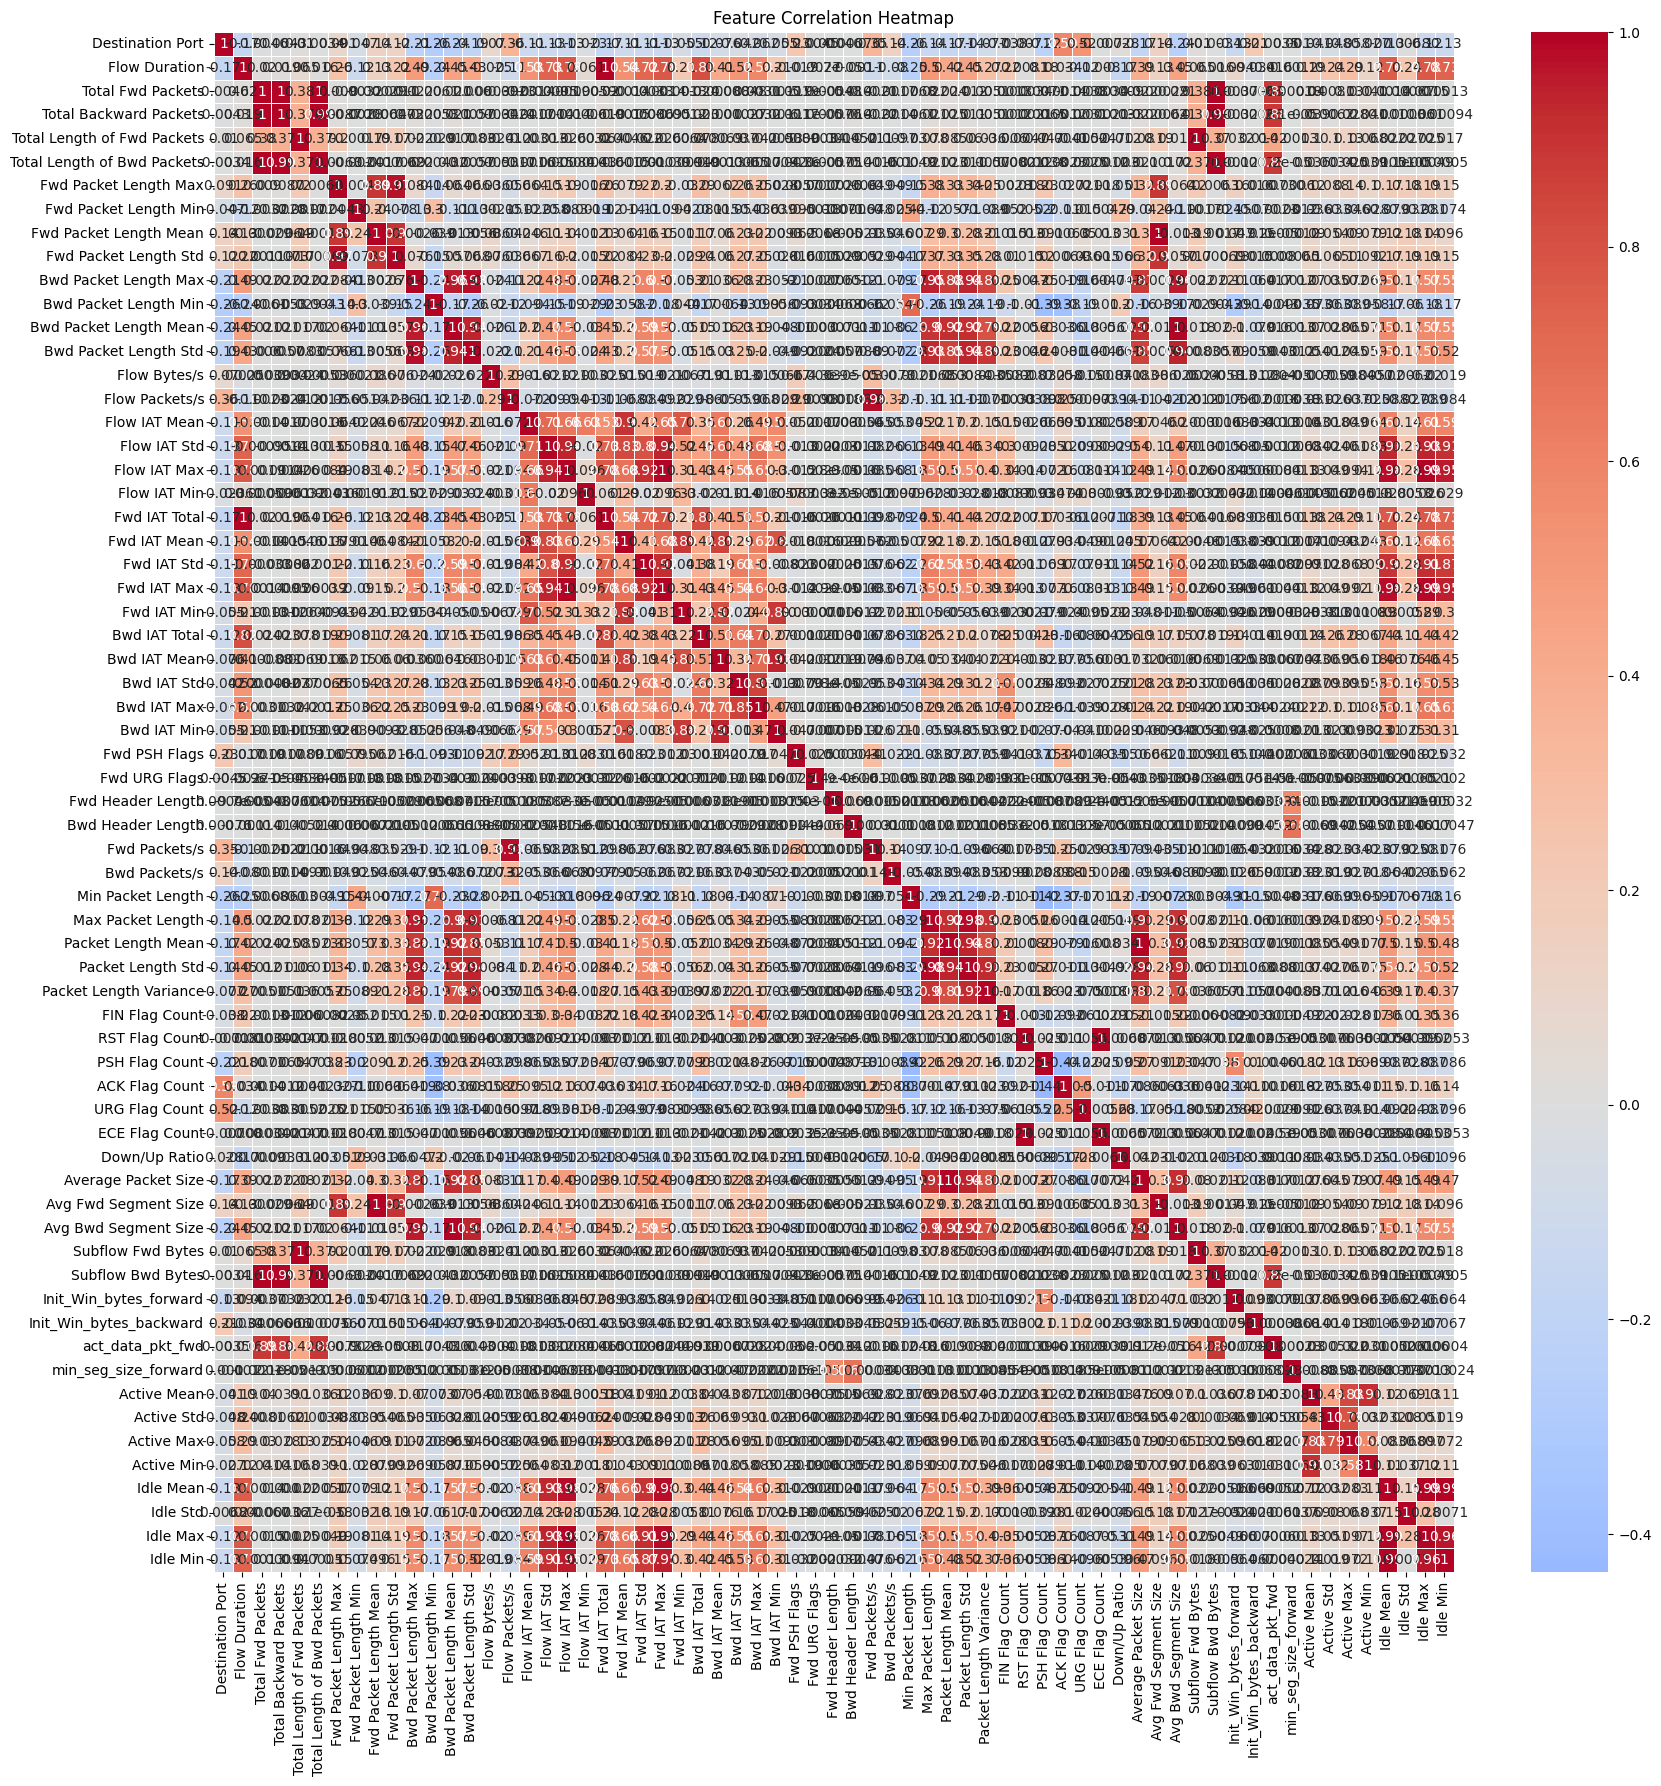

In [39]:
# Análise de correlação:
numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [40]:
# Print aos pares com alta correlação e isolar os near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.968

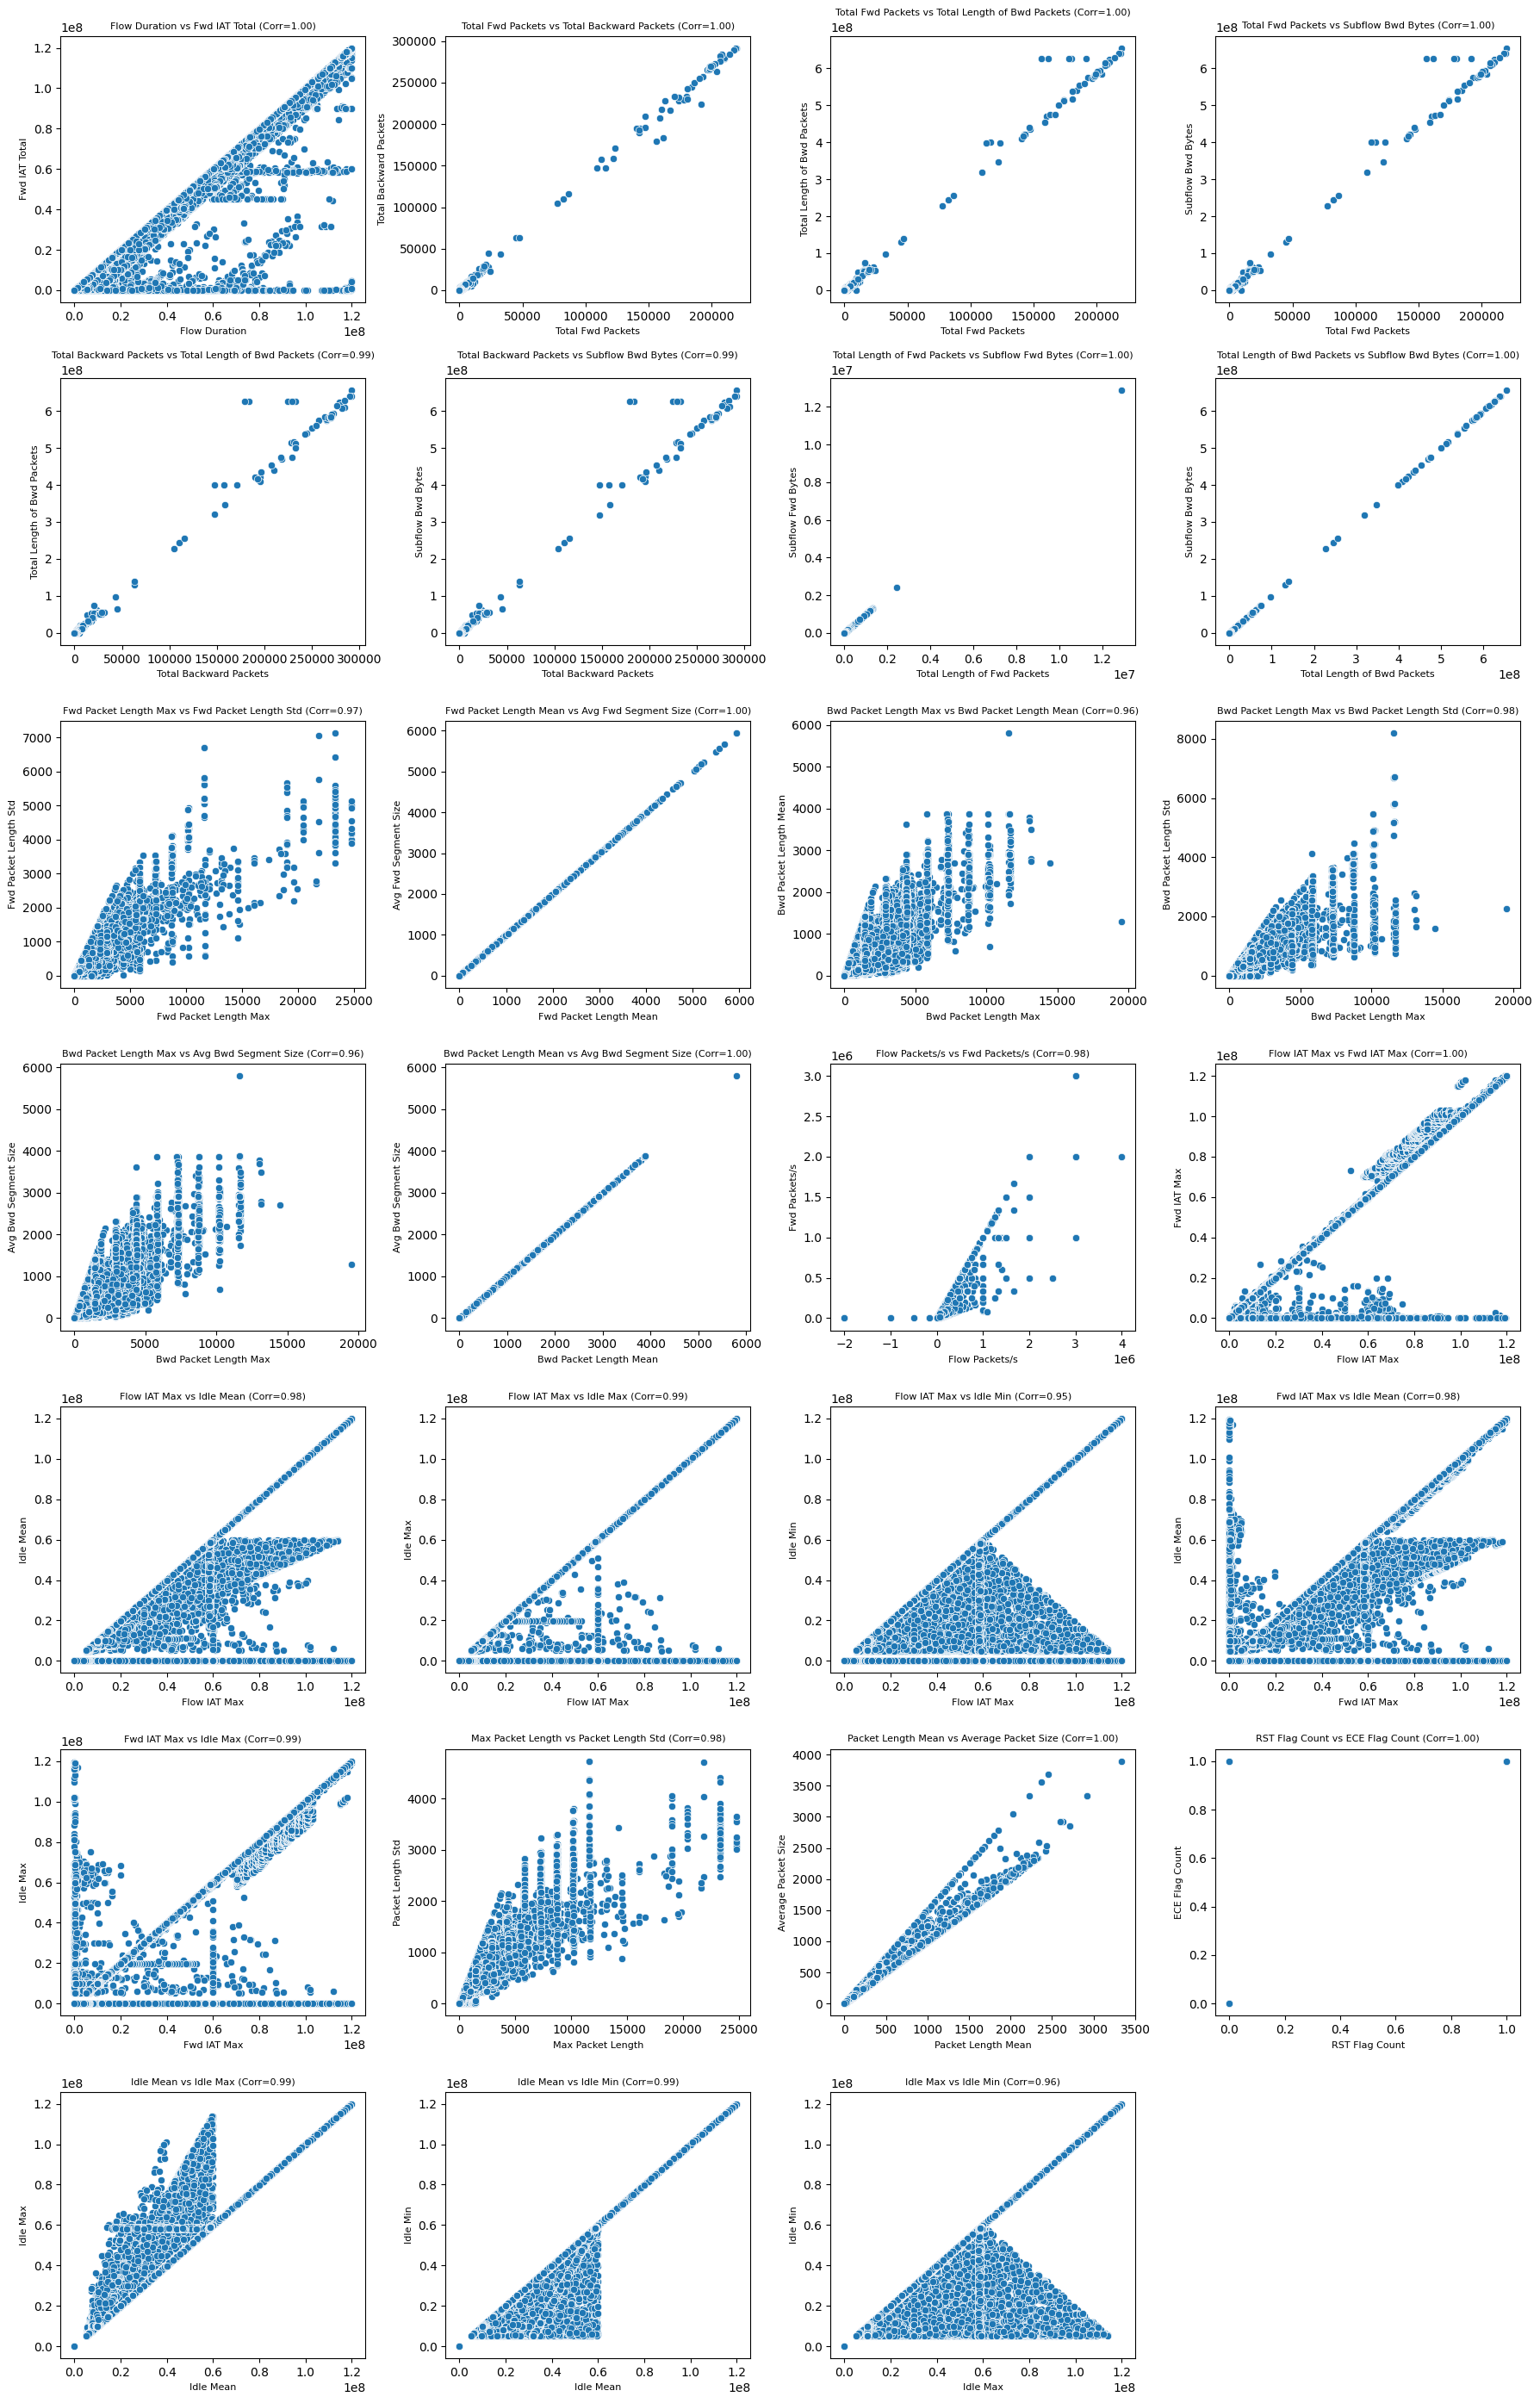

In [41]:
# Gráficos com pares com correlação altamente elevada para melhor visualização

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Esconder gráficos não utilizados
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [42]:
# Remoção de colunas com multicolinearidade near/perfect
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# Drop dessas colunas
data.drop(columns=selected_columns, inplace=True)

In [43]:
# Update às variáveis e apresentção do novo datashape
numeric_features, categorical_features = get_feature_types(data)
data.shape

(2520751, 61)

# 3.3. Outliers

<Figure size 1500x1000 with 0 Axes>

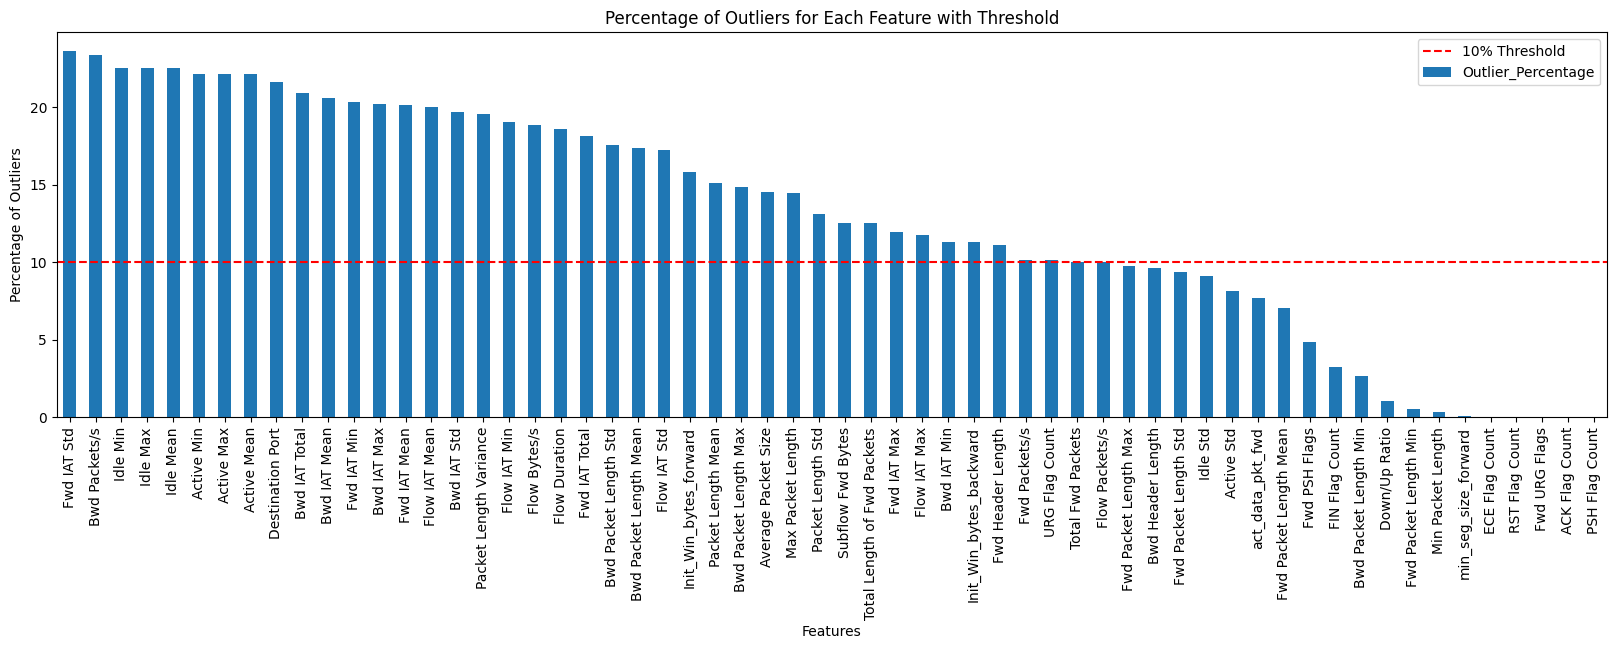

In [44]:
# Cálculo da percentagem de outliers
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Conversão para um DataFrame
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define o threshold
threshold = 10

# Identifica features com percentagem de outliers acima do threshold
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Grágico para os outliers acima do threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [45]:
# Print às features com high outlier percentages
print(f"Features with outlier percentage above {threshold}%:\n")
print(high_outlier_features.sort_values('Outlier_Percentage', ascending=False))

del outliers_df

Features with outlier percentage above 10%:

                             Outlier_Percentage
Fwd IAT Std                           23.657989
Bwd Packets/s                         23.402391
Idle Min                              22.501508
Idle Max                              22.501508
Idle Mean                             22.501508
Active Min                            22.167917
Active Max                            22.167917
Active Mean                           22.167917
Destination Port                      21.645137
Bwd IAT Total                         20.926819
Bwd IAT Mean                          20.602908
Fwd IAT Min                           20.366311
Bwd IAT Max                           20.187555
Fwd IAT Mean                          20.126462
Flow IAT Mean                         19.985512
Bwd IAT Std                           19.700319
Packet Length Variance                19.538899
Flow IAT Min                          19.072649
Flow Bytes/s                          18.84

# 3.4. Distribuição dos Dados

Entnder a Distribuição Ajuda na Seleção do Modelo

In [46]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Teste de Anderson-Darling para verificar distribuição normal
    result = stats.anderson(data[col], dist='norm')

    # Compara estatiticamente com um valor a 5% de nível de significância
    if result.statistic < result.critical_values[2]:  # 5% nível de significância
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features seguem uma distribuição normal - Aceitar a hipótese nula')
print(f'{not_norm_dist} features não seguem uma distribuição normal - Rejeitar a hipótese nula')


# Isso significa que os dados podem ser assimétricos, com outliers ou simplesmente seguir uma distribuição diferente
# Pode não ser possível aplicar regressão linear ou outros modelos que assumem normalidade

0 features seguem uma distribuição normal - Aceitar a hipótese nula
60 features não seguem uma distribuição normal - Rejeitar a hipótese nula


# 3.5. Não Balanceamento das Classes

In [47]:
# Conta as ocorrências de cada tipo de ataque e coloca num DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Conta o total para cada caso
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Cálculo das respetivas percentagens
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


A análise anterior apresenta uma clara falta de equilíbrio:
- Dominânica da classe 'BENIGN' - 83,1%
- Mesmo DoS sendo a 2ª classe mais relevante, tem muito poucas contagens
- Mesmo após o agrupamento, classes como 'Bots', 'Web Attacks' e 'Brute Force' são muito poucas

Implicações Possíveis
- Pode levar a um modelo 'biased' - com elevada Accuracy mas pouco recall e precisão, para classes mais pequenas
- Métricas de Perfromance - Devem ser bem escolhidas

Ideias para Problemas no Treino do Modelo
- Classes de Peso para penalizar erros nas classes minoritárias
- Métodos como Random Forest podem melhorar as Previsões
- Cross-Validation com folds representativas
- Diminuir as samples da classe maioritaria

In [48]:
del attack_counts_df

# ! Como lidar com desbalanceamento !

- Ajustar o Peso das Classes no Modelo
- Usar Técnicas de Reamostragem
- Usar Algoritmos que Lidam Bem com Desequilíbrio (Random Forest e XGBoost)
- Fazer Cross-Validation com Stratified Folds
- Balancear a Sample do Dataset

# 5. Importância das Features

Próximo passo será para determinar o melhor teste estatístico 

In [49]:
# Levene's Test
# p-value < 0.05 
# São avaliadas se as variâncias das features numéricas são homogéneas entre os diferentes tipos de ataque
# p-value < 0.05  variâncias não são homogéneas
# p-value >= 0.05  variâncias são homogéneas
variance_result = analyze_variance_homogeneity(data, numeric_features)

# As features dadas por estes resultados podem não ser úteis para o modelo

Sem grupos válidos suficientes para realizar o teste de  Levene's para as features: Fwd URG Flags
Sem grupos válidos suficientes para realizar o teste de  Levene's para as features: RST Flag Count
Sem grupos válidos suficientes para realizar o teste de  Levene's para as features: ECE Flag Count


In [ ]:
# Análise dos resultados
no_significant_results = True

for feature, result in variance_result.items():   
    if result['p-value'] > 0.05:  
        print(f"\nFeature: {feature}")  
        print(f"  - Test Statistic: {result['Statistic']:.4f}")  
        print(f"  - p-value: {result['p-value']:.4f}")  
        print("  - Interpretação: As variâncias não são significativamnte diferentes (fail to reject null hypothesis).")  
        no_significant_results = False

# Se nenhuma feature tiver p-values > 0.05  
if no_significant_results:  
    print("\nNenhuma feature tem p-values acima the 0.05. Todas as features têm diferenças significativas na variância.")


# Os resultados indicam que três features podem não ser úteis para distinguir os ataques.


Feature: Fwd Header Length
  - Test Statistic: 0.1504
  - p-value: 0.9890
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: Bwd Header Length
  - Test Statistic: 0.3305
  - p-value: 0.9213
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: min_seg_size_forward
  - Test Statistic: 0.6496
  - p-value: 0.6271
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).


# Análise da Importância de Features utilizando Kruskal-Wallis

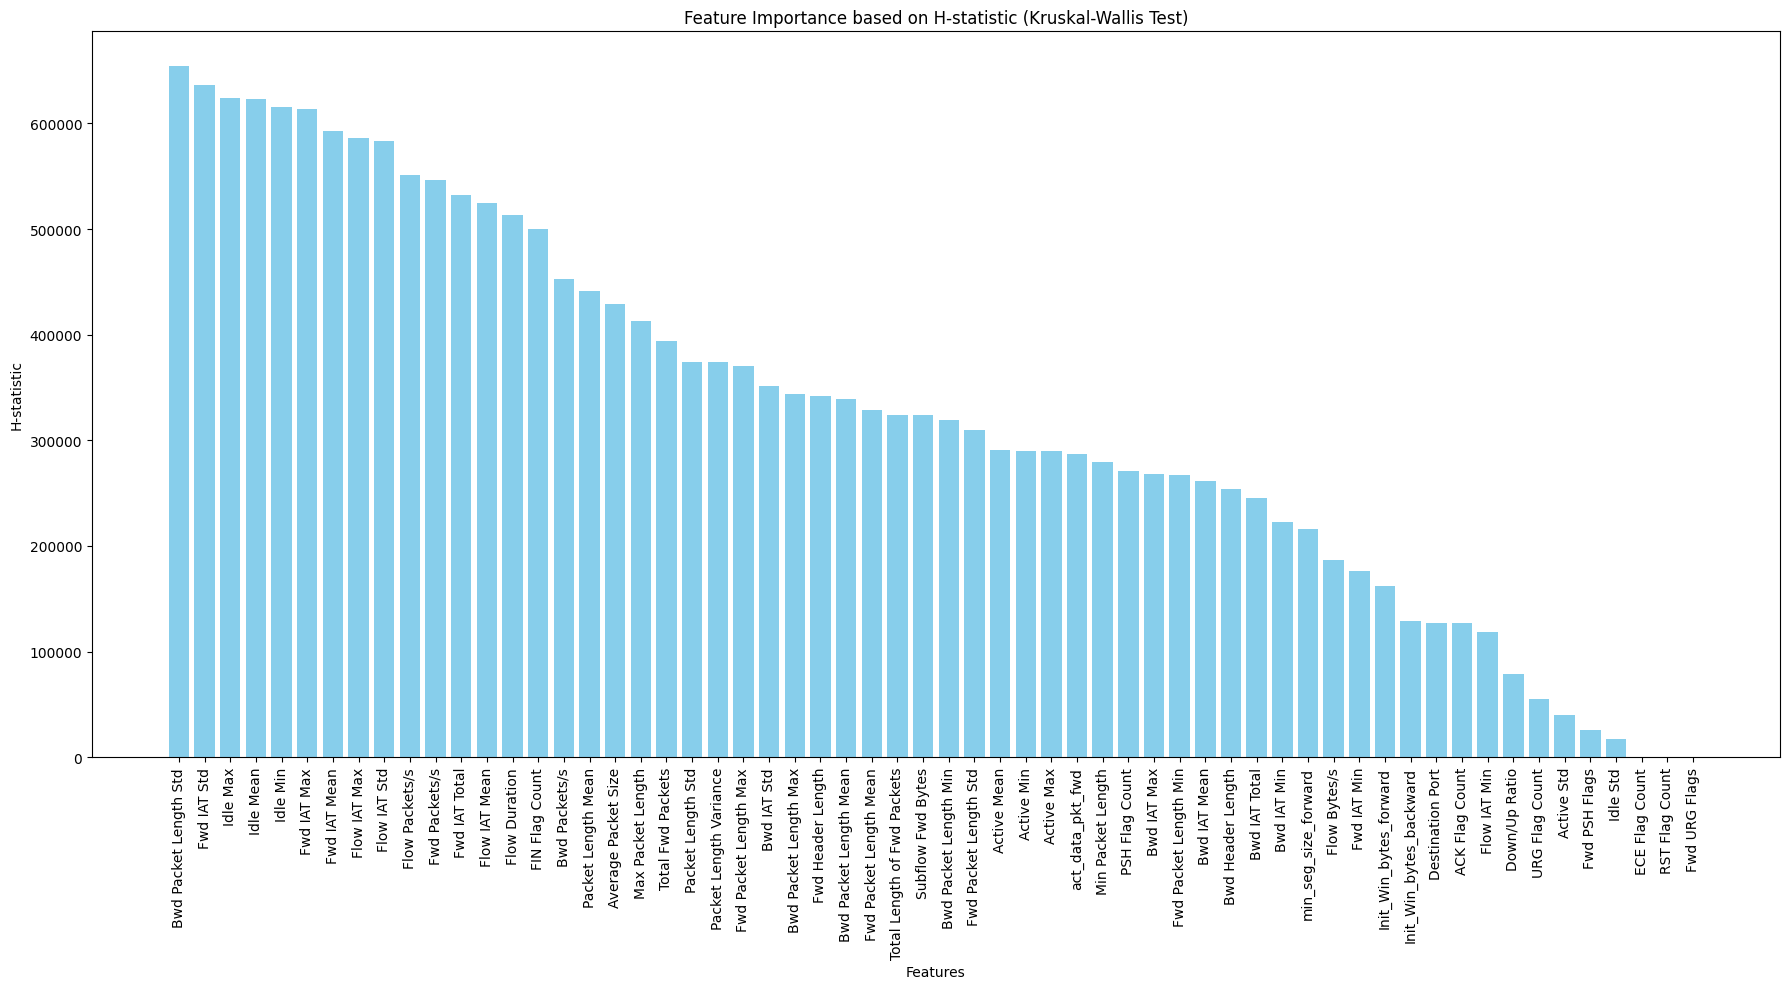

In [ ]:
# Avaliação da importância das features numéricas na distinção dos diferentes tipos de ataque (Attack Type) usando o teste de Kruskal-Wallis
h_p_stats = analyze_feature_importance(data, numeric_features)

# Treinar um Modelo Random Forest e Analisar as Features Importance Scores

Cross-Validation Score: 0.9986 ± 0.0001

Classification Report:

                precision    recall  f1-score   support

          Bots       0.87      0.75      0.80       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      0.99      0.99     27208
   Web Attacks       0.99      0.97      0.98       643

      accuracy                           1.00    756226
     macro avg       0.98      0.96      0.97    756226
  weighted avg       1.00      1.00      1.00    756226




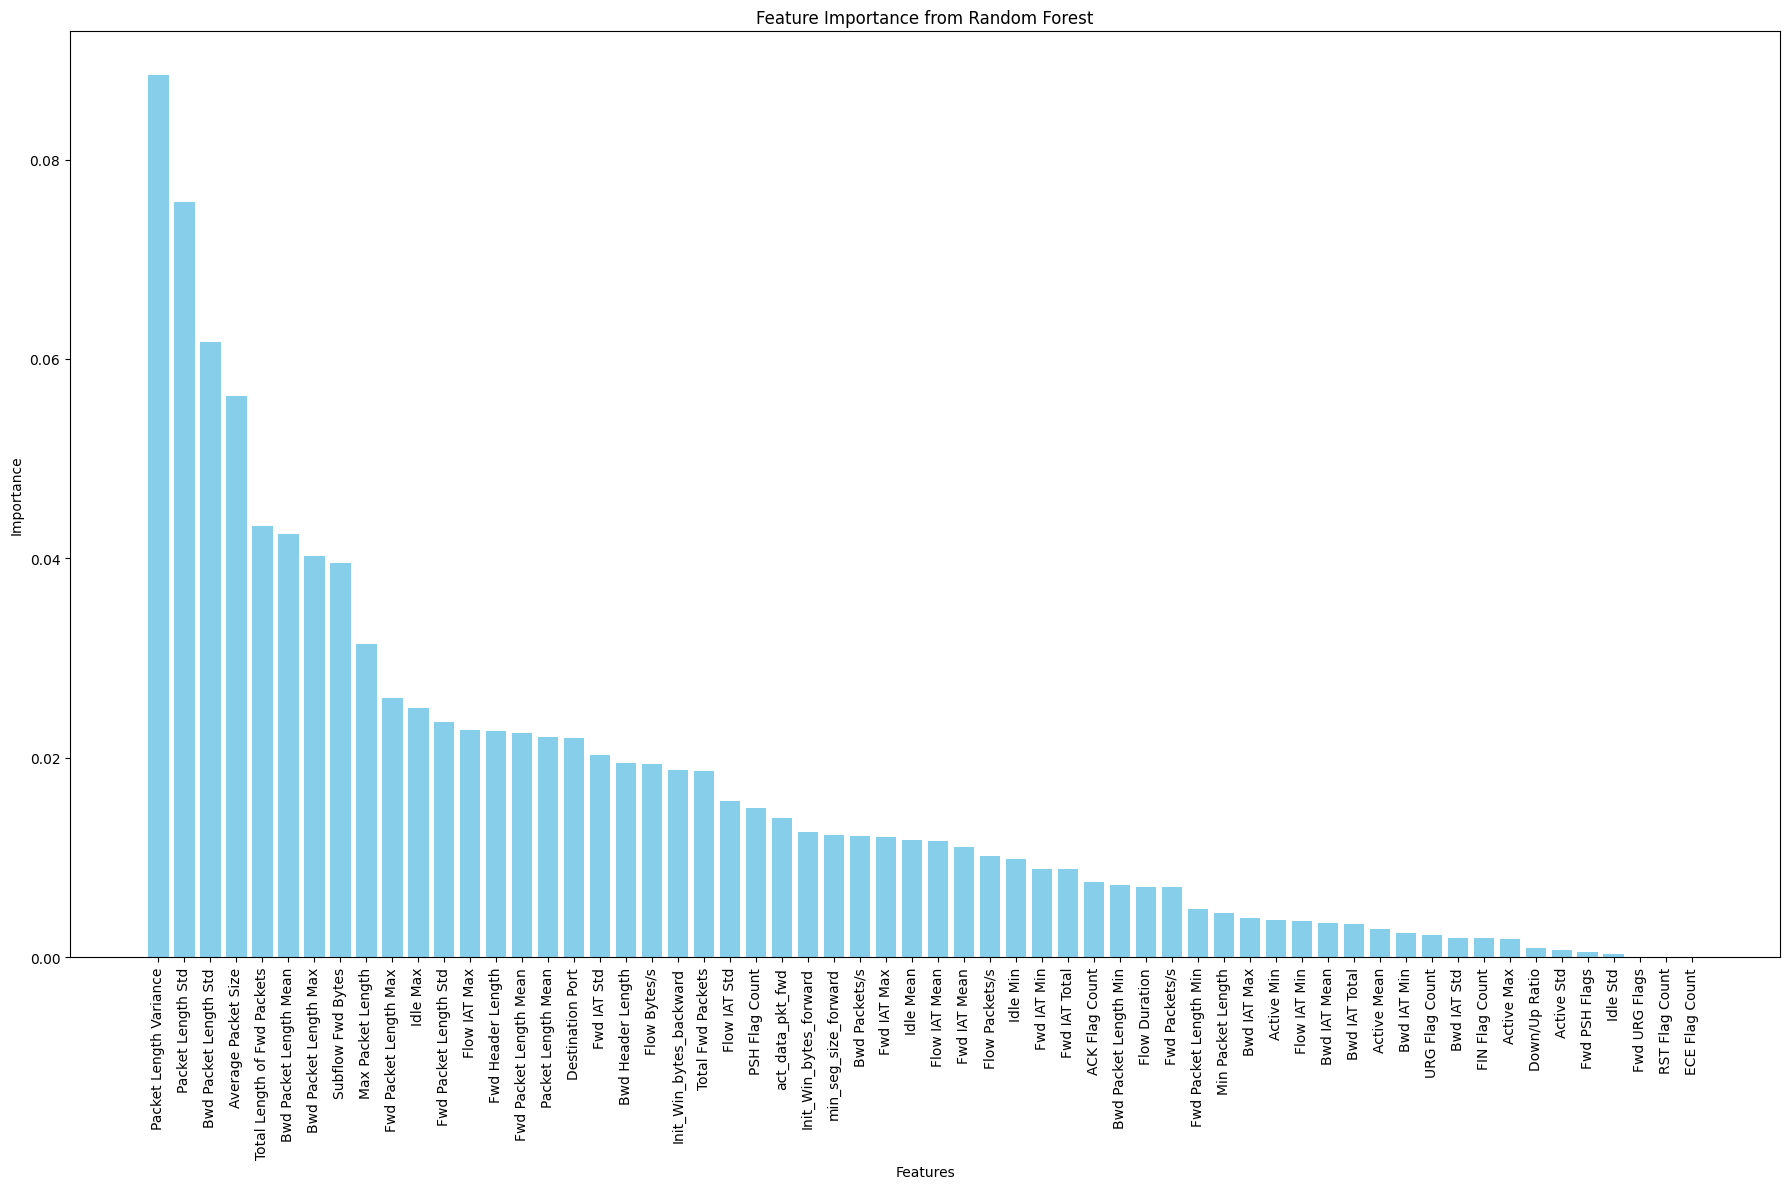

In [ ]:
# Análise da Feature Importance com Random Forest
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(data, numeric_features)

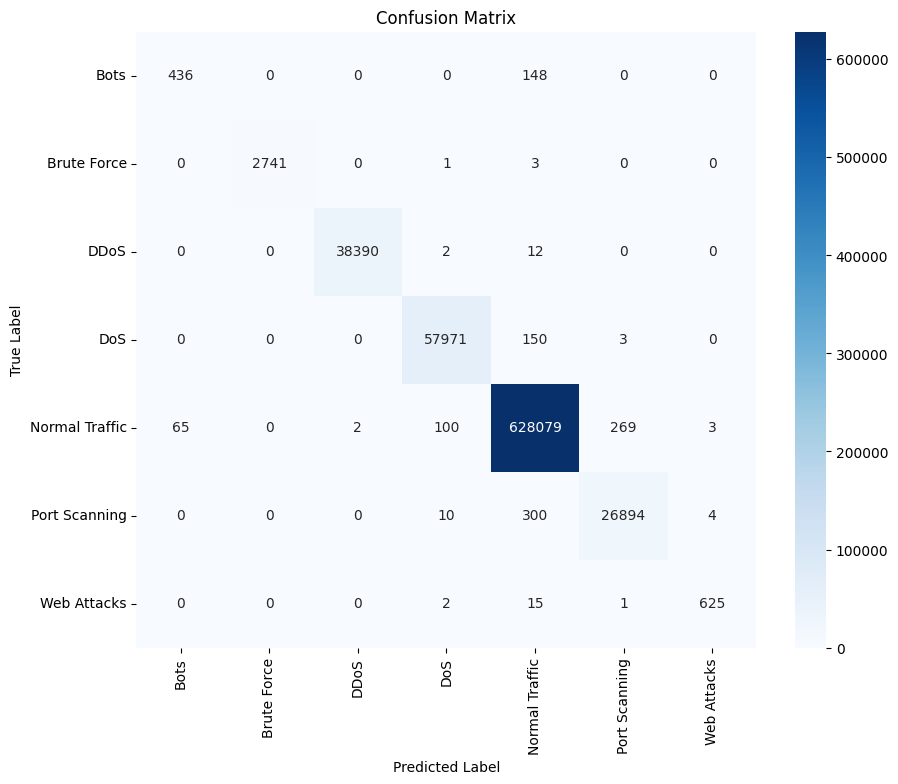

In [ ]:
# Avaliação do Random Forest com base nas features selecionadas
# Matriz Confusão com heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Criação de uma tabela comparativa que exibe as importâncias de features de dois métodos distintos.

# Preparação do DS para comparação
h_p_stats.reset_index(inplace = True)
h_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

comparison_tb = feature_importance_tree.merge(h_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

Feature    Importance    H-statistic       p-value
0        Packet Length Variance  8.843718e-02  373845.434316  0.000000e+00
1             Packet Length Std  7.571175e-02  373896.560353  0.000000e+00
2         Bwd Packet Length Std  6.172347e-02  654400.346609  0.000000e+00
3           Average Packet Size  5.624429e-02  429097.080675  0.000000e+00
4   Total Length of Fwd Packets  4.322997e-02  324367.440051  0.000000e+00
5        Bwd Packet Length Mean  4.247465e-02  338820.640791  0.000000e+00
6         Bwd Packet Length Max  4.028314e-02  343538.176327  0.000000e+00
7             Subflow Fwd Bytes  3.954123e-02  324367.440051  0.000000e+00
8             Max Packet Length  3.137641e-02  413042.599252  0.000000e+00
9         Fwd Packet Length Max  2.600953e-02  370387.060527  0.000000e+00
10                     Idle Max  2.496540e-02  623703.285065  0.000000e+00
11        Fwd Packet Length Std  2.354705e-02  309782.604424  0.000000e+00
12                 Flow IAT Max  2.282351e-02  586397.926092  0.000000e+00
13            Fwd Header Length  2.272335e-02  341947.780347  0.000000e+00
14       Fwd Packet Length Mean  2.249981e-02  329034.643034  0.000000e+00
15           Packet Length Mean  2.208319e-02  441151.659878  0.000000e+00
16             Destination Port  2.200138e-02  127451.569396  0.000000e+00
17                  Fwd IAT Std  2.030035e-02  636060.304071  0.000000e+00
18            Bwd Header Length  1.951277e-02  254081.487827  0.000000e+00
19                 Flow Bytes/s  1.939310e-02  186291.833757  0.000000e+00
20      Init_Win_bytes_backward  1.876224e-02  128571.984543  0.000000e+00
21            Total Fwd Packets  1.868806e-02  393964.909878  0.000000e+00
22                 Flow IAT Std  1.564716e-02  583436.800056  0.000000e+00
23               PSH Flag Count  1.493329e-02  270942.047682  0.000000e+00
24             act_data_pkt_fwd  1.397063e-02  287409.354036  0.000000e+00
25       Init_Win_bytes_forward  1.255020e-02  162210.599019  0.000000e+00
26         min_seg_size_forward  1.224041e-02  216470.155490  0.000000e+00
27                Bwd Packets/s  1.218638e-02  452485.894562  0.000000e+00
28                  Fwd IAT Max  1.205117e-02  613363.701705  0.000000e+00
29                    Idle Mean  1.178974e-02  622826.256521  0.000000e+00
30                Flow IAT Mean  1.162057e-02  524746.801923  0.000000e+00
31                 Fwd IAT Mean  1.109604e-02  592885.051978  0.000000e+00
32               Flow Packets/s  1.017972e-02  551209.601857  0.000000e+00
33                     Idle Min  9.888381e-03  615783.745791  0.000000e+00
34                  Fwd IAT Min  8.893321e-03  176671.295387  0.000000e+00
35                Fwd IAT Total  8.853171e-03  532165.815112  0.000000e+00
36               ACK Flag Count  7.544760e-03  127167.916547  0.000000e+00
37        Bwd Packet Length Min  7.230642e-03  319130.563542  0.000000e+00
38                Flow Duration  7.072937e-03  512832.362613  0.000000e+00
39                Fwd Packets/s  6.993625e-03  546767.500688  0.000000e+00
40        Fwd Packet Length Min  4.827752e-03  267272.208416  0.000000e+00
41            Min Packet Length  4.467452e-03  279082.481784  0.000000e+00
42                  Bwd IAT Max  3.926809e-03  267908.439961  0.000000e+00
43                   Active Min  3.689290e-03  290276.956143  0.000000e+00
44                 Flow IAT Min  3.586044e-03  118774.072042  0.000000e+00
45                 Bwd IAT Mean  3.440396e-03  261577.108238  0.000000e+00
46                Bwd IAT Total  3.358225e-03  245520.740404  0.000000e+00
47                  Active Mean  2.862933e-03  290585.115390  0.000000e+00
48                  Bwd IAT Min  2.402796e-03  222705.282747  0.000000e+00
49               URG Flag Count  2.252757e-03   55244.795175  0.000000e+00
50                  Bwd IAT Std  1.955417e-03  351480.669309  0.000000e+00
51               FIN Flag Count  1.901730e-03  500318.644205  0.000000e+00
52                   Active Max  1.812621e-03  28

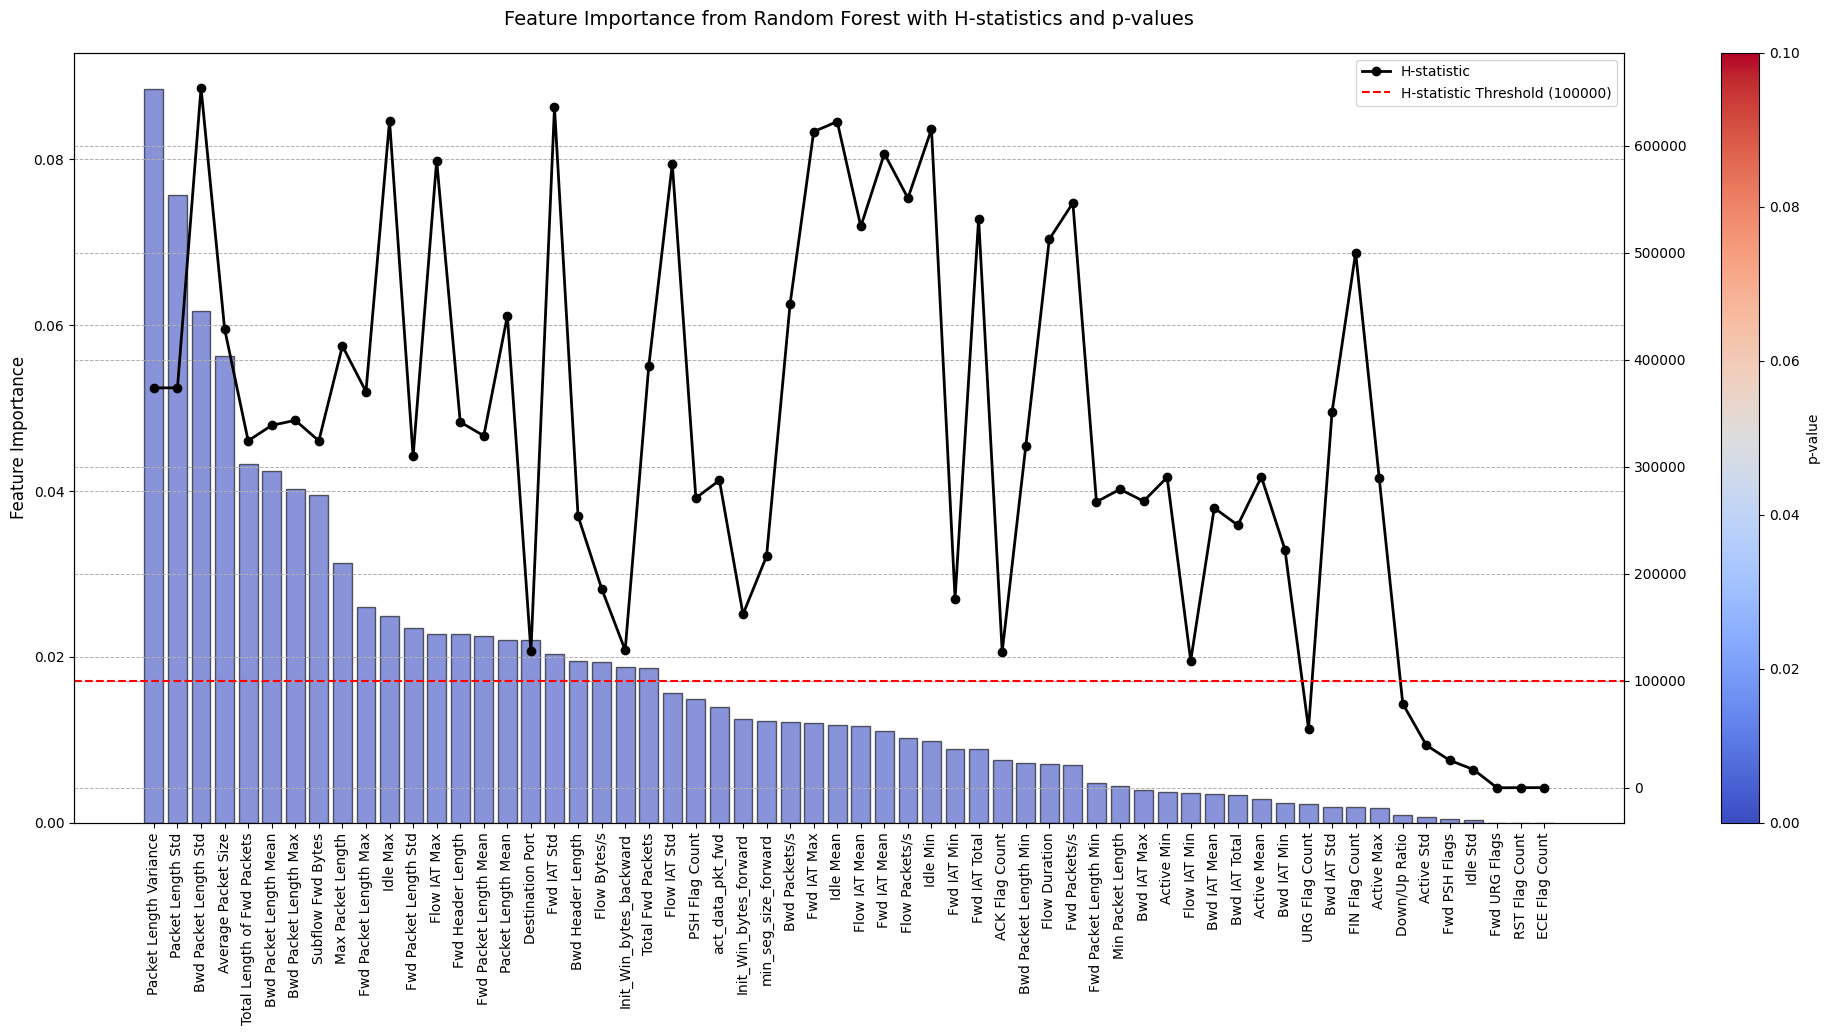

In [ ]:
# Comparar a importância das features com a estatística H-statistic e os p-values

# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()

In [ ]:
# Remoção de features com baixa importância
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std', 'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']
data.drop(columns=cols_to_remove, inplace=True)

In [ ]:
# Limpeza do Dataset
data.to_csv('cicids2017_cleaned.csv', index=False)